# Feature Generation

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.preprocessing import LabelEncoder

ks = pd.read_csv('./data/ks-projects-201801.csv', parse_dates=['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

In [6]:
ks.head(1)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,outcome,hour,day,month,year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0,12,11,8,2015


In [4]:
baseline_data.head(2)

,goal,hour,day,month,year,outcome,category,currency,country
0,1000.0,12,11,8,2015,0,108,5,9
1,30000.0,4,2,9,2017,0,93,13,22


## Interactions

In [11]:
# Interaction feature between category and country
interactions = ks['category'] + "_" + ks['country']
interactions.head(10)

0            Poetry_GB
1    Narrative Film_US
2    Narrative Film_US
3             Music_US
4      Film & Video_US
5       Restaurants_US
6              Food_US
7            Drinks_US
8    Product Design_US
9       Documentary_US
dtype: object

In [9]:
interactions.nunique()

2750

In [10]:
label_enc = LabelEncoder()
data_interaction = baseline_data.assign(category_country=label_enc.fit_transform(interactions))
data_interaction.head()

,goal,hour,day,month,year,outcome,category,currency,country,category_country
0,1000.0,12,11,8,2015,0,108,5,9,1900
1,30000.0,4,2,9,2017,0,93,13,22,1630
2,45000.0,0,12,1,2013,0,93,13,22,1630
3,5000.0,3,17,3,2012,0,90,13,22,1595
4,19500.0,8,4,7,2015,0,55,13,22,979


## Number of projects in the last week

In [32]:
ks.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            378651, 378652, 378653, 378654, 378655, 378656, 378657, 378658,
            378659, 378660],
           dtype='int64', length=375862)

In [31]:
# Create a pandas series where the index is the launch date and the column is the index
launched = pd.Series(ks.index, index=ks.launched, name="count_7_days").sort_index()
launched

launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
                        ...  
2017-12-29 03:22:32    339929
2017-12-29 21:06:11     62039
2017-12-31 13:53:53     11463
2018-01-01 00:54:41    167940
2018-01-02 03:05:10     15604
Name: count_7_days, Length: 375862, dtype: int64

In [30]:


#For example launched.rolling('7d') creates a rolling window that contains all the data in the previous 7 days. 
#The window contains the current record, so if we want to count all the previous projects but not the current one, we'll need to subtract 1.
count_7_days = launched.rolling('7d').count() - 1
print(count_7_days.head(20))

launched
1970-01-01 01:00:00     0.0
1970-01-01 01:00:00     1.0
1970-01-01 01:00:00     2.0
1970-01-01 01:00:00     3.0
1970-01-01 01:00:00     4.0
1970-01-01 01:00:00     5.0
1970-01-01 01:00:00     6.0
2009-04-21 21:02:48     0.0
2009-04-23 00:07:53     1.0
2009-04-24 21:52:03     2.0
2009-04-25 17:36:21     3.0
2009-04-27 14:10:39     4.0
2009-04-28 13:55:41     5.0
2009-04-29 02:04:21     5.0
2009-04-29 02:58:50     6.0
2009-04-29 04:37:37     7.0
2009-04-29 05:26:32     8.0
2009-04-29 06:43:44     9.0
2009-04-29 13:52:03    10.0
2009-04-29 22:08:13    11.0
Name: count_7_days, dtype: float64


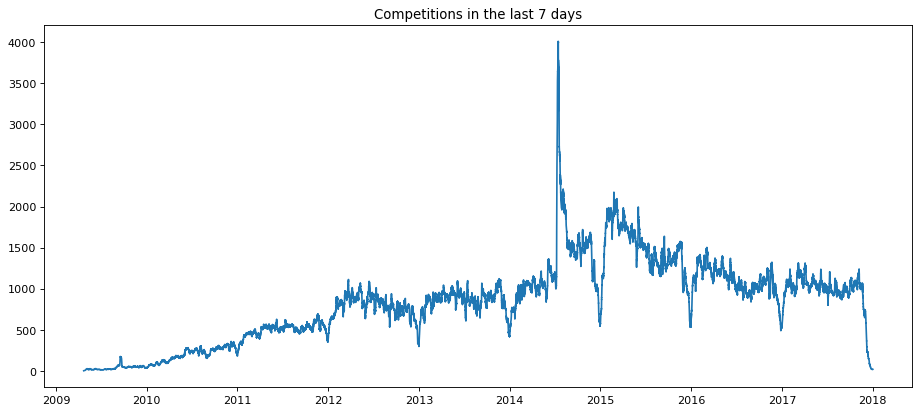

In [28]:
# Ignore records with broken launch dates
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(count_7_days[7:]);
plt.title("Competitions in the last 7 days");

In [33]:
launched.values

array([ 94579, 319002, 247913, ...,  11463, 167940,  15604])

In [34]:
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)

In [35]:
count_7_days

0         1409.0
1          957.0
2          739.0
3          907.0
4         1429.0
           ...  
378656    1482.0
378657     505.0
378658     238.0
378659    1100.0
378660     542.0
Name: count_7_days, Length: 375862, dtype: float64

In [36]:
#Now join the new feature with the other data again using .join since we've matched the index.
baseline_data.join(count_7_days).head(10)

,goal,hour,day,month,year,outcome,category,currency,country,count_7_days
0,1000.0,12,11,8,2015,0,108,5,9,1409.0
1,30000.0,4,2,9,2017,0,93,13,22,957.0
2,45000.0,0,12,1,2013,0,93,13,22,739.0
3,5000.0,3,17,3,2012,0,90,13,22,907.0
4,19500.0,8,4,7,2015,0,55,13,22,1429.0
5,50000.0,13,26,2,2016,1,123,13,22,1284.0
6,1000.0,18,1,12,2014,1,58,13,22,1119.0
7,25000.0,20,1,2,2016,0,41,13,22,1391.0
8,125000.0,18,24,4,2014,0,113,13,22,1043.0
9,65000.0,21,11,7,2014,0,39,13,22,3199.0


## Time since the last project in the same category

A handy method for performing operations within groups is to use `.groupby` then `.transform.` The `.transform` method takes a function then passes a series or dataframe to that function for each group. This returns a dataframe with the same indices as the original dataframe. In our case, we'll perform a groupby on "category" and use transform to calculate the time differences for each category

In [37]:
def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds() / 3600.

In [40]:
df = ks[['category', 'launched']].sort_values('launched')
df

,category,launched
94579,Theater,1970-01-01 01:00:00
319002,Publishing,1970-01-01 01:00:00
247913,Music,1970-01-01 01:00:00
48147,Art,1970-01-01 01:00:00
75397,Film & Video,1970-01-01 01:00:00
...,...,...
339929,Hip-Hop,2017-12-29 03:22:32
62039,Web,2017-12-29 21:06:11
11463,Tabletop Games,2017-12-31 13:53:53
167940,Comic Books,2018-01-01 00:54:41


In [45]:
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas.head(20)

,launched
94579,NaN
319002,NaN
247913,NaN
48147,NaN
75397,NaN
2842,0.000000
273779,NaN
169268,NaN
322000,NaN
138572,NaN


We get NaNs here for projects that are the first in their category. We'll need to fill those in with something like the mean or median.

In [49]:
# Final time since last project
timedeltas = timedeltas.fillna(timedeltas.median())
timedeltas.head(10)

,launched
0,18.606111
1,5.592778
2,1.313611
3,0.635000
4,16.661389
5,2.629722
6,0.367500
7,12.286111
8,14.243611
9,0.174722


In [50]:
timedeltas = timedeltas.reindex(baseline_data.index)
timedeltas.head(10)

,launched
0,18.606111
1,5.592778
2,1.313611
3,0.635000
4,16.661389
5,2.629722
6,0.367500
7,12.286111
8,14.243611
9,0.174722


## Transforming numerical features

The distribution of the values in "goal" shows that most projects have goals less than 5000 USD. However, there is a long tail of goals going up to $100,000. Some models work better when the features are normally distributed, so it might help to transform the goal values.

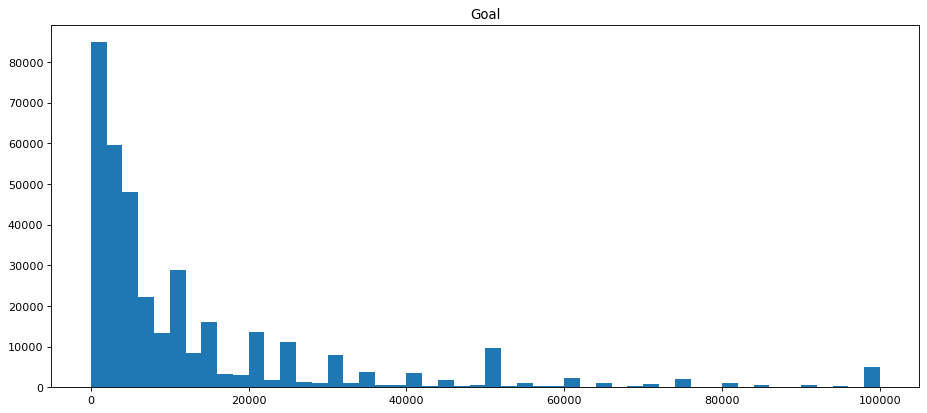

In [52]:
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(ks.goal, range=(0, 100000), bins=50);
plt.title('Goal');

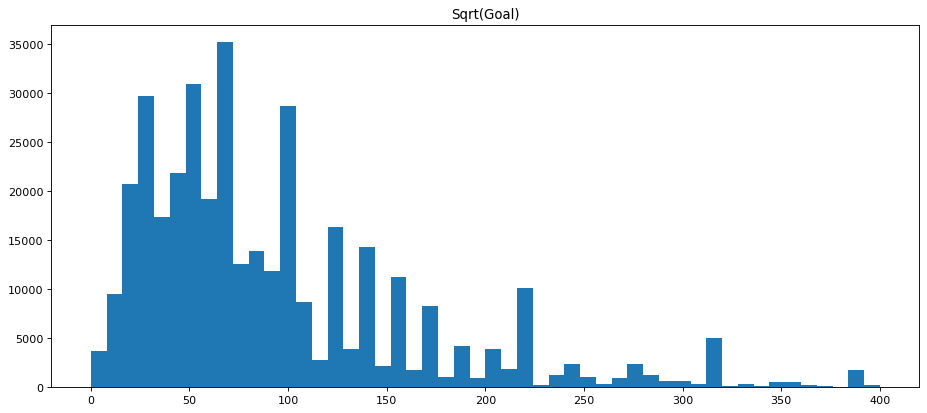

In [54]:
#squareRoot
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(np.sqrt(ks.goal), range=(0, 400), bins=50);
plt.title('Sqrt(Goal)');

The log transformation won't help our model since tree-based models are scale invariant. However, this should help if we had a linear model or neural network.

Other transformations include squares and other powers, exponentials, etc. These might help the model discriminate, like the kernel trick for SVMs. Again, it takes a bit of experimentation to see what works. One method is to create a bunch of new features and later choose the best ones with feature selection algorithms.